In [1]:
from tqdm.notebook import tqdm
import logging

import torch
from torch.optim import Adam
import torch.nn.functional as F

from myresdecoder import VoxResNet as Decoder
from myresencoder import VoxResNet as Encoder
from utils import *
from dataset import get_dataloader
from scheduler import ScheduledOptim

In [2]:
device = "cpu"
image_size = 512
batch_size = 8
total_steps = 30000
warmup_steps = 2000


logging.basicConfig(
    filename="logs.txt",
    filemode='w',
    format='%(asctime)s, %(name)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S',
    level=logging.DEBUG
)

dataloader = get_dataloader(batch_size=batch_size, path="/Users/jonathan/Downloads/celeba_hq_256")

encoder = Encoder(3, 512).to(device)
decoder = Decoder(512, 3).to(device)
opt = Adam(list(encoder.parameters()) + list(decoder.parameters()), betas=(.9, .999))
sched = ScheduledOptim(opt, total_steps=total_steps, base=1e-3, decay_type="cosine", warmup_steps=warmup_steps)
# count_parameters(encoder, model_name="Encoder")
# count_parameters(decoder, model_name="Decoder")

resume = "/Users/jonathan/Downloads/ae-ckpt-030000.pt"
if resume is not None:
    state = torch.load(resume, map_location=device)
    encoder.load_state_dict(state["encoder"])
    decoder.load_state_dict(state["decoder"])
    opt.load_state_dict(state["opt"])
    sched.load_state_dict(state["sched"])
    logging.info(f"All keys matched successfully, loaded from {resume}.")

In [20]:
epsilon = 0

with torch.no_grad():
    data = next(dataloader).to(device)
    b = data.shape[0]
    if data.shape[-1] != image_size:
        data = F.interpolate(data, image_size, mode="bilinear", align_corners=True)
    z = encoder(data + epsilon * torch.randn_like(data))
    reconstruction = decoder(z)
    print(reconstruction.min(), reconstruction.max())

/Users/jonathan/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


tensor(-1.3086) tensor(1.3323)


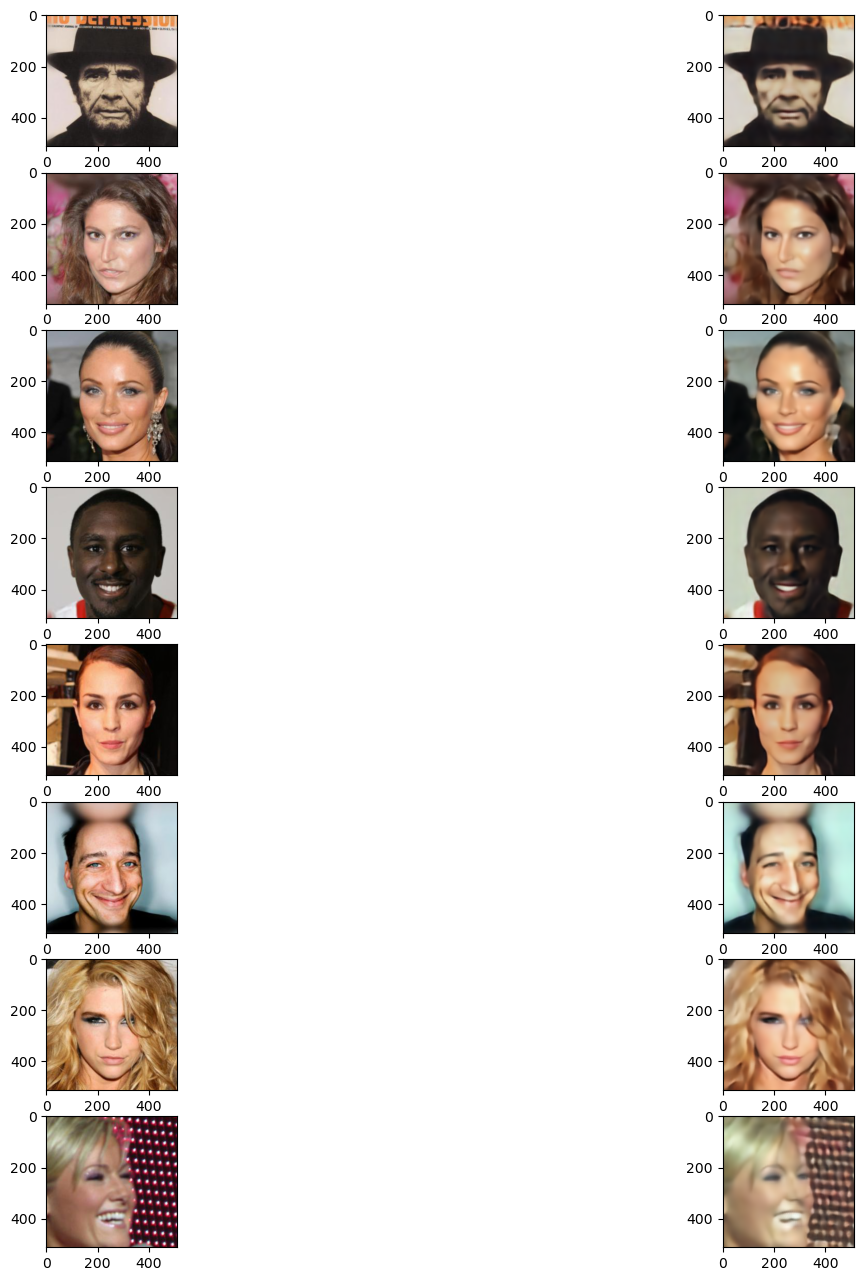

In [21]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(8, 2, figsize=(16,16))

for i in range(8):
    img = data[i].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    axs[i][0].imshow(img)

    img = reconstruction[i].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    axs[i][1].imshow(img)